## 1. Import library

In [1]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from google.colab import files

## 2. Upload dataset

In [2]:
uploaded = files.upload()

Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv


## 3. Understand dataset

In [3]:
df = pd.read_csv('ambient_temperature_system_failure.csv')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [5]:
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [6]:
print(df['value'].head(10))

0    69.880835
1    71.220227
2    70.877805
3    68.959400
4    69.283551
5    70.060966
6    69.279765
7    69.369608
8    69.166714
9    68.986083
Name: value, dtype: float64


In [7]:
print(df['value'].mean())

71.2424327082882


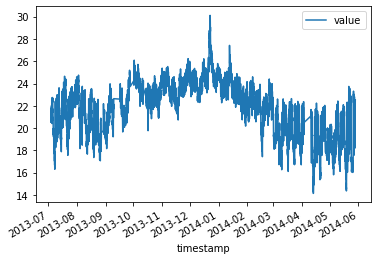

In [8]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

In [9]:
print(df['timestamp'])

0      2013-07-04 00:00:00
1      2013-07-04 01:00:00
2      2013-07-04 02:00:00
3      2013-07-04 03:00:00
4      2013-07-04 04:00:00
               ...        
7262   2014-05-28 11:00:00
7263   2014-05-28 12:00:00
7264   2014-05-28 13:00:00
7265   2014-05-28 14:00:00
7266   2014-05-28 15:00:00
Name: timestamp, Length: 7267, dtype: datetime64[ns]


## 4. Feature engineering

In [10]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [11]:
df['hours']

0        0
1        1
2        2
3        3
4        4
        ..
7262    11
7263    12
7264    13
7265    14
7266    15
Name: hours, Length: 7267, dtype: int64

In [12]:
df['daylight']

0       0
1       0
2       0
3       0
4       0
       ..
7262    1
7263    1
7264    1
7265    1
7266    1
Name: daylight, Length: 7267, dtype: int64

In [13]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [14]:
df['DayOfTheWeek']

0       3
1       3
2       3
3       3
4       3
       ..
7262    2
7263    2
7264    2
7265    2
7266    2
Name: DayOfTheWeek, Length: 7267, dtype: int64

In [15]:
df['WeekDay']

0       1
1       1
2       1
3       1
4       1
       ..
7262    1
7263    1
7264    1
7265    1
7266    1
Name: WeekDay, Length: 7267, dtype: int64

In [16]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df['time_epoch']

0       13728960
1       13728996
2       13729032
3       13729068
4       13729104
          ...   
7262    14012748
7263    14012784
7264    14012820
7265    14012856
7266    14012892
Name: time_epoch, Length: 7267, dtype: int64

## 5. Models

### 5.1. Cluster only

In [17]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
data

,value,hours,daylight,DayOfTheWeek,WeekDay
0,21.044908,0,0,3,1
1,21.789015,1,0,3,1
2,21.598781,2,0,3,1
3,20.533000,3,0,3,1
4,20.713084,4,0,3,1
...,...,...,...,...,...
7262,22.427892,11,1,2,1
7263,22.318309,12,1,2,1
7264,22.248092,13,1,2,1
7265,22.125126,14,1,2,1


In [18]:
# Take useful feature and standardize them
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


In [19]:
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
data

array([[ 0.08987032,  2.23882419],
       [-0.01278056,  2.10139375],
       [-0.01270697,  2.01220009],
       ...,
       [-0.92227757, -0.46789802],
       [-0.92959969, -0.56056451],
       [-0.99679206, -0.68134455]])

In [20]:
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262
...,...,...
7262,-0.663130,-0.218870
7263,-0.669607,-0.292067
7264,-0.679271,-0.366858
7265,-0.684664,-0.439514


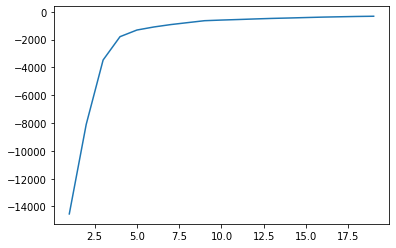

In [21]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [22]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

11    605
4     596
2     590
7     582
6     581
10    573
8     547
3     528
0     444
12    443
1     396
14    354
5     350
13    342
9     336
Name: cluster, dtype: int64

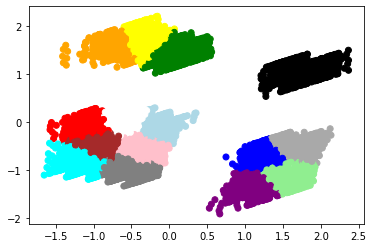

In [23]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [24]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [25]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


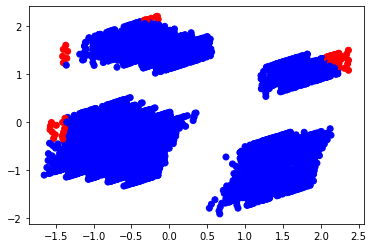

In [26]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

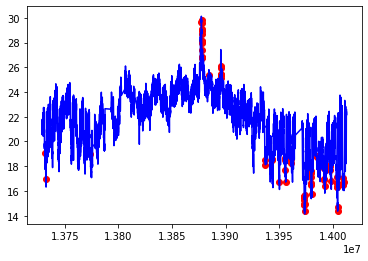

In [27]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


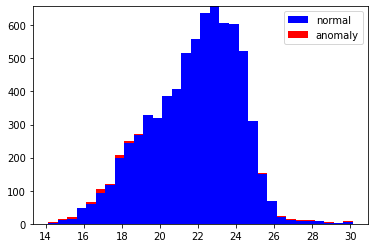

In [28]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()